<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/Data_Analyst_Agent_Cohere_and_Langchain.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Tool Use - Simple Data Analyst Agent with Cohere and Langchain

Tool use is a method whichs allows developers to connect Cohere's Command models to external tools like search engines, APIs, databases, and other software tools. Just like how [Retrieval-Augmented Generation (RAG)](https://docs.cohere.com/docs/retrieval-augmented-generation-rag) allows a model to use an external data source to improve factual generation, tool use is a capability that allows retrieving data from multiple sources. But it goes beyond simply retrieving information and is able to use software tools to execute code, or even create entries in a CRM system.

In this notebook, we'll see how we can use two tools to create a simple data analyst agent that is able to search the web and run code in a python interpreter. This agent uses Cohere's Command R+ mode and Langchain.


![](https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/images/tool-use-notebook-header.png)

# Environment
Let's start by installing the required libraries

In [1]:
! pip install --quiet langchain langchain_cohere langchain_experimental

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.37.2 requires tokenizers<0.19,>=0.14, but you have tokenizers 0.19.1 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Setup
We'll need a Cohere API key here. Grab your key and paste it in the next slide if you have one, or [register](https://dashboard.cohere.ai/welcome/register) and create a new API key.

In [2]:
### LLMs
import os
os.environ['COHERE_API_KEY'] = "jz9VzYozZSNH0Hs9QJO5BQ7SNfGmXu5Fgn2mXsYl"

In [3]:
# Create the Cohere chat model
from langchain_cohere.chat_models import ChatCohere
chat = ChatCohere(model="command-r-plus", temperature=0.3)

# Define tools
Our simple data analyst will be equipped with a web search tool, and a python interpreter (which we can use to run plotting code, for example).

[all the tools](https://python.langchain.com/docs/integrations/tools/)

### Web search
Let's first equip our agent with web search! We can use the Tivaly API for this. Head on to [tavily.com](https://tavily.com) and grab an API key to use here.

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ['TAVILY_API_KEY'] = "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"

internet_search = TavilySearchResults()
internet_search.name = "internet_search"
internet_search.description = "Returns a list of relevant document snippets for a textual query retrieved from the internet."


from langchain_core.pydantic_v1 import BaseModel, Field
class TavilySearchInput(BaseModel):
    query: str = Field(description="Query to search the internet with")
internet_search.args_schema = TavilySearchInput

### Python interpreter tool
Let's equip our agent with a python interpreter!

In [5]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

# from langchain_core.pydantic_v1 import BaseModel, Field
class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
repl_tool.args_schema = ToolInput


# Create ReAct Agent: the data analyst

In [6]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [7]:
# Create the prompt
prompt = ChatPromptTemplate.from_template("{input}")


# Create the ReAct agent
agent = create_cohere_react_agent(
    llm=chat,
    tools=[internet_search, repl_tool],
    prompt=prompt,
)

In [8]:
agent_executor = AgentExecutor(agent=agent, tools=[internet_search, repl_tool], verbose=True)

# Let's ask a question to the data analyst



> Entering new AgentExecutor chain...

First, I will search for the 3 tech companies with the highest market cap in the United States in 2024. Then, I will search for the number of full-time employees at each of these companies. Finally, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'internet_search', 'parameters': {'query': '3 tech companies with highest market cap in the United States 2024'}}
[{'url': 'https://www.nytimes.com/interactive/2024/01/22/business/magnificent-seven-stocks-tech.html', 'content': "Change in prices since Oct. 12, 2022\n+450\n%\n+400\nNvidia\n+350\n+300\n+250\n+200\nMeta\nOct. 12, 2022:\nS&P 500’s most recent low\n+150\nMicrosoft\n+100\nAlphabet\nApple\nAmazon\n+50\nS&P 500\n0\nTesla\n–50\n’22\n’23\n’24\n+450\n%\n+400\nNvidia\n+350\n+300\n+250\n+200\nMeta\nOct. 12, 2022:\nS&P 500’s most recent low\n+150\nMicrosoft\n+100\nAlphabet\nApple\nAmazon\n+50\nS&P 500\n0\nTesla\n–50\nO\nN\nD\nJ\nF\nM\nA\nM\nJ\

Python REPL can execute arbitrary code. Use with caution.



I found that the number of full-time employees at Apple, Microsoft, and Nvidia in 2024 are 161,000, 221,000, and 29,600, respectively. Now, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import matplotlib.pyplot as plt\n\n# Data\ncompanies = ['Apple', 'Microsoft', 'Nvidia']\nnum_employees = [161000, 221000, 29600]\n\n# Plot\nplt.bar(companies, num_employees)\nplt.xlabel('Company')\nplt.ylabel('Number of Full-Time Employees')\n\n# Save the plot\nplt.savefig('number_of_full_time_employees.png')"}}
Relevant Documents: 1,3,4,9,10,11,14,16,19,20
Cited Documents: 1,3,4,9,10,11,14,16,19,20
Answer: Here is a plot of the number of full-time employees at the 3 tech companies with the highest market cap in the United States in 2024:

![Number of Full-Time Employees](number_of_full_time_employees.png)
Grounded answer: Here is a plot of the number of full-time employees at the 3 tech companies 

{'input': 'Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024.',
 'output': 'Here is a plot of the number of full-time employees at the 3 tech companies with the highest market cap in the United States in 2024:\n\n! [Number of Full-Time Employees](number_of_full_time_employees.png)',
 'citations': [CohereCitation(start=135, end=203, text='! [Number of Full-Time Employees](number_of_full_time_employees.png)', documents=[{'output': '', 'id': 'doc_20'}], document_ids={'doc_20'})]}

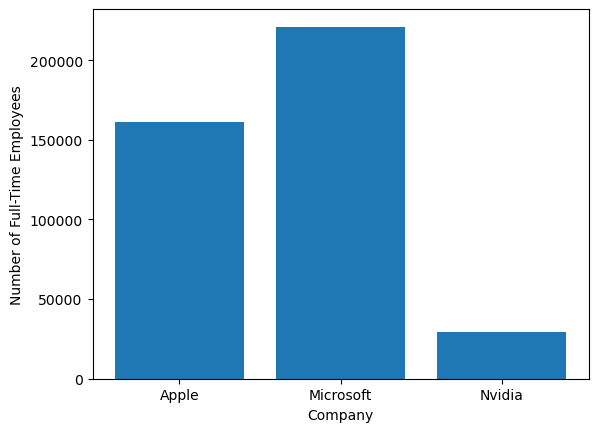

In [9]:
agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024.",
})

In [ ]:
# notice that the model did websearch calls, then used python to do some analysis
# the model can even self-debug itself if the python code was wrong

# Let's ask another question to the data analyst -- which requires a direct answer

In [ ]:
agent_executor.invoke({
    "input": "Hey how are you?",
})



> Entering new AgentExecutor chain...
Plan: I will respond to the user's greeting.
Action: ```json
[
    {
        "tool_name": "directly_answer",
        "parameters": {}
    }
]
```
Relevant Documents: None
Cited Documents: None
Answer: Hey, I'm doing well, thank you for asking! How can I help you today?
Grounded answer: Hey, I'm doing well, thank you for asking! How can I help you today?

> Finished chain.


{'input': 'Hey how are you?',
 'output': "Hey, I'm doing well, thank you for asking! How can I help you today?",
 'citations': []}

This is a simple example to get you start. There [are many tools](https://python.langchain.com/docs/integrations/tools/) you can equip your agent with. Once youre comfortable with these ideas, you can also proceed to define your tools (see [Multi-step tool use in Action](https://docs.cohere.com/docs/multi-step-tool-use#multi-step-tool-use-in-action)).
